# Code Used for Case Study: Model Engineering

The numbering of the below notebook follows that of the case study paper.

## 0. Importing Libraries

In [1]:
!python -V

Python 3.6.13 :: Anaconda, Inc.


In [2]:
import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import holidays
import datetime

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU

from sklearn.preprocessing import MinMaxScaler

## 2. Understanding Data

Loading the data

In [4]:
df = pd.read_csv('sickness_table.csv', index_col = 0)
df.head()

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,2016-04-05,63,7236.0,1700,90,0.0,0.0


As the data type for 'date' is incorrect, the data type is fixed with the below code.

In [5]:
df['date'] = pd.to_datetime(df['date'])

Keeping dates as list for later usage.

In [6]:
dates = df['date']

The dataset is described as below.

In [7]:
np.round(df.describe(include = 'all'), 1)

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
count,1152,1152.0,1152.0,1152.0,1152.0,1152.0,1152.0
unique,1152,NaN,NaN,NaN,NaN,NaN,NaN
top,2016-09-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
first,2016-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-05-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,68.8,7919.5,1820.6,90.0,34.7,16.3
std,NaN,14.3,1290.1,80.1,0.0,79.7,53.4
min,NaN,36.0,4074.0,1700.0,90.0,0.0,0.0
25%,NaN,58.0,6978.0,1800.0,90.0,0.0,0.0


The number of standby drivers needed is visualised.

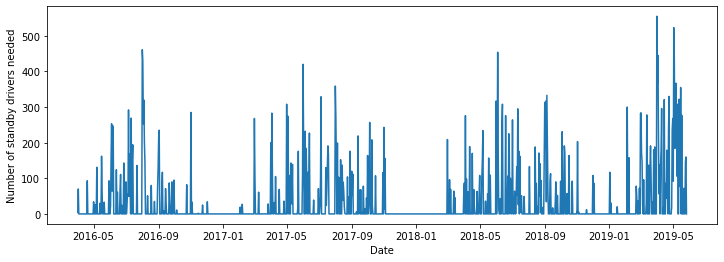

In [8]:
plt.figure(figsize = (12, 4))
plt.plot(df['date'], df['sby_need'])
plt.xlabel('Date')
plt.ylabel('Number of standby drivers needed')
plt.savefig('Figure1.png', dpi = 1500, bbox_inches = 'tight', pad_inches = 0)
plt.show()

The histrogram is plotted to understand the distribution.

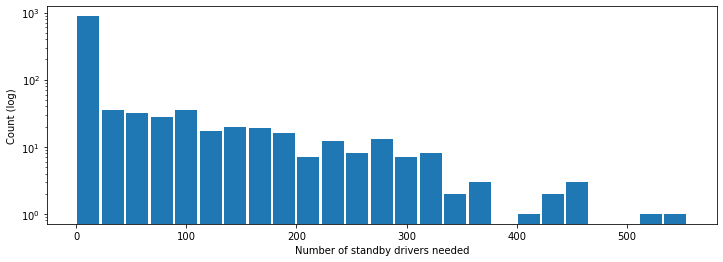

In [9]:
plt.figure(figsize = (12, 4))
plt.hist(df['sby_need'], bins = 25, rwidth = 0.90)
plt.yscale('log')
plt.xlabel('Number of standby drivers needed')
plt.ylabel('Count (log)')
plt.savefig('Figure2.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)
plt.show()

Below columns are not usable for the prediction, thus are removed from the dataset.

In [10]:
for column in ['n_duty', 'n_sby', 'dafted']:
    df.drop(column, axis = 1, inplace = True)

## 3. Feature Engineering

As the necessary number might be related to weekends and holidays, those features are added.

In [11]:
germany_holidays = holidays.Germany(years = [2016, 2017, 2018, 2019])

In [12]:
df['wknd'] = 0
df['hldy'] = 0
df['wknd_hldy'] = 0

for i in range(len(df)):
    date = df.loc[i, 'date']
    
    if date.weekday() >= 5:
        df.loc[i, 'wknd'] = 1
    if date in germany_holidays:
        df.loc[i, 'hldy'] = 1
    if date.weekday() >= 5 or date in germany_holidays:
        df.loc[i, 'wknd_hldy'] = 1
        
df.head()

,date,n_sick,calls,sby_need,wknd,hldy,wknd_hldy
0,2016-04-01,73,8154.0,4.0,0,0,0
1,2016-04-02,64,8526.0,70.0,1,0,1
2,2016-04-03,68,8088.0,0.0,1,0,1
3,2016-04-04,71,7044.0,0.0,0,0,0
4,2016-04-05,63,7236.0,0.0,0,0,0


The day of the week/month/year, month, and the week of year are also added due to possible correlation.

In [13]:
df['dyofwk']   = None
df['dyofmnth'] = None
df['dyofyr']   = None
df['mnth']     = None
df['wkofyr']   = None

for i in range(len(df)):
    date = df.loc[i, 'date']
    
    df.loc[i, 'dyofwk']   = date.strftime('%a')
    df.loc[i, 'dyofmnth'] = date.strftime('%d')
    df.loc[i, 'dyofyr']   = date.strftime('%j')
    df.loc[i, 'mnth']     = date.strftime('%b')
    df.loc[i, 'wkofyr']   = date.strftime('%U')
    
df.head()

,date,n_sick,calls,sby_need,wknd,hldy,wknd_hldy,dyofwk,dyofmnth,dyofyr,mnth,wkofyr
0,2016-04-01,73,8154.0,4.0,0,0,0,Fri,01,092,Apr,13
1,2016-04-02,64,8526.0,70.0,1,0,1,Sat,02,093,Apr,13
2,2016-04-03,68,8088.0,0.0,1,0,1,Sun,03,094,Apr,14
3,2016-04-04,71,7044.0,0.0,0,0,0,Mon,04,095,Apr,14
4,2016-04-05,63,7236.0,0.0,0,0,0,Tue,05,096,Apr,14


For those features that are not continuous, one-hot-encoding is applied.

In [14]:
df = pd.get_dummies(df, drop_first = True)
df.head()

,date,n_sick,calls,sby_need,wknd,hldy,wknd_hldy,dyofwk_Mon,dyofwk_Sat,dyofwk_Sun,...,wkofyr_44,wkofyr_45,wkofyr_46,wkofyr_47,wkofyr_48,wkofyr_49,wkofyr_50,wkofyr_51,wkofyr_52,wkofyr_53
0,2016-04-01,73,8154.0,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2016-04-02,64,8526.0,70.0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2016-04-03,68,8088.0,0.0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2016-04-04,71,7044.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2016-04-05,63,7236.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Engineering past values of 'sby_need', 'n_sick', and 'calls' as features.

In [15]:
for i in range(46, 366):
    df[f'sby_need{-i}d'] = df['sby_need'].shift(i)
    df[f'n_sick{-i}d']   = df['n_sick'].shift(i)
    df[f'calls{-i}d']    = df['calls'].shift(i)
    
df.head()

,date,n_sick,calls,sby_need,wknd,hldy,wknd_hldy,dyofwk_Mon,dyofwk_Sat,dyofwk_Sun,...,calls-362d,sby_need-363d,n_sick-363d,calls-363d,sby_need-364d,n_sick-364d,calls-364d,sby_need-365d,n_sick-365d,calls-365d
0,2016-04-01,73,8154.0,4.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-04-02,64,8526.0,70.0,1,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-04-03,68,8088.0,0.0,1,0,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-04-04,71,7044.0,0.0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-04-05,63,7236.0,0.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dropping rows with NA due to the above feature engineering.

In [16]:
print(df.shape)
df.dropna(axis = 0, inplace = True)
print(df.shape)

(1152, 1432)
(787, 1432)


The three columns below are dropped as those values cannot be obtained at the time of forecasting.

In [17]:
for column in ['date', 'n_sick', 'calls']:
    df.drop(column, axis = 1, inplace = True)

Engineered dataset looks like below.

In [18]:
df.head()

,sby_need,wknd,hldy,wknd_hldy,dyofwk_Mon,dyofwk_Sat,dyofwk_Sun,dyofwk_Thu,dyofwk_Tue,dyofwk_Wed,...,calls-362d,sby_need-363d,n_sick-363d,calls-363d,sby_need-364d,n_sick-364d,calls-364d,sby_need-365d,n_sick-365d,calls-365d
365,200.0,1,0,1,0,1,0,0,0,0,...,7044.0,0.0,68.0,8088.0,70.0,64.0,8526.0,4.0,73.0,8154.0
366,0.0,1,0,1,0,0,1,0,0,0,...,7236.0,0.0,71.0,7044.0,0.0,68.0,8088.0,70.0,64.0,8526.0
367,283.0,0,0,0,1,0,0,0,0,0,...,6492.0,0.0,63.0,7236.0,0.0,71.0,7044.0,0.0,68.0,8088.0
368,117.0,0,0,0,0,0,0,0,1,0,...,6204.0,0.0,70.0,6492.0,0.0,63.0,7236.0,0.0,71.0,7044.0
369,0.0,0,0,0,0,0,0,0,0,1,...,7614.0,0.0,64.0,6204.0,0.0,70.0,6492.0,0.0,63.0,7236.0


## 4. Methods and Results

### Metrics

Three metrics are defined as below. </br>
The active rate calculates the rate of standby drivers that are activated. The higher the active rate is, the better. </br>
The unattended rate calculates the rate of requests that are not attended with standby drivers. The lower the unattended rate is, the better.

In [19]:
def RMSE(y_true, y_pred = 90):
    for i in range(len(y_true)):
        # If a prediction is below 0, it is altered to 0
        if y_pred[i] < 0:
            y_pred[i] = 0
    
    return int(np.sqrt(np.mean((y_test - y_pred) ** 2)))

In [20]:
def active_rate(y_true, y_pred):
    active_num = 0 # the number of drivers activeted
    y_pred_ttl = 0 # the total number of drivers
    
    for i in range(len(y_true)):
        # If a prediction is below 0, it is altered to 0
        if y_pred[i] < 0:
            y_pred[i] = 0
        
        # If a prediction is below the true value, the prediction is added to 'active_num'
        if y_true[i] >= y_pred[i]:
            active_num += y_pred[i]
        # If a prediction is above the true value, the actual value is added to 'active_num'
        else:
            active_num += y_true[i]

        y_pred_ttl += y_pred[i]
        
    # Dividing the number of drivers activeted by the total number
    active_rate = active_num / y_pred_ttl
    
    # Returning the active rate
    return str('{:.1f}'.format(active_rate * 100)) + '%'

In [21]:
def unattended_rate(y_true, y_pred = 90):
    unattended_ttl = 0 # the number of requests unattended with standby drivers
    y_true_ttl     = 0 # the total number of requests
    
    for i in range(len(y_true)):
        # If a prediction is below 0, it is altered to 0
        if y_pred[i] < 0:
            y_pred[i] = 0            
        
        # If a prediction is below its true value, the difference is added to 'unattended_ttl'
        if y_true[i] >= y_pred[i]:
            unattended      = y_true[i] - y_pred[i]
            unattended_ttl += unattended

        y_true_ttl += y_true[i]
        
    # Diving the number of requested unatteded with the standyb drivers by the total number
    unattended_rate = unattended_ttl / y_true_ttl
    
    # Returning the unattended rate
    return str('{:.1f}'.format(unattended_rate * 100)) + '%'

### Train Test Split

Splitting the engineered dataset into training and test dataset as below.

In [22]:
x = df.drop('sby_need', axis = 1)
y = df['sby_need']

x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size = 0.3, shuffle = False)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(550, 1428)
(237, 1428)
(550,)
(237,)


Updatingthe dates range for the test dataset.

In [23]:
dates = dates[-y_test.shape[0]:]

### Fitting to Models

Defining a function so that the three metrics above can be calculated easily.

In [24]:
def fit2model(x_train, x_test, y_train, y_test, model = None, algorithm = '', note = ' '):
    if model == None:
        pred = np.array([90] * len(y_test))
    else:
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
    
    result = []
    result.append(algorithm)
    result.append(RMSE(y_test, pred))
    result.append(active_rate(y_test, pred))
    result.append(unattended_rate(y_test, pred))
    result.append(note)
    
    return result

List for the results to be stored and its columns.

In [25]:
results = []
columns = ['Algorithm', 'RMSE', 'Active Rate', 'Unattended Rate', 'Note']

As a first baseline model, linear regression is built and its results are shown with the benchmarck of  the constant 90 driver plan.

In [26]:
lr = LinearRegression()
results.append(fit2model(x_train, x_test, y_train, y_test, None, '(n_sby = 90)', 'Benchmark'))
results.append(fit2model(x_train, x_test, y_train, y_test, lr, 'Linear Regression'))

pd.DataFrame(results, columns = columns)

,Algorithm,RMSE,Active Rate,Unattended Rate,Note
0,(n_sby = 90),112,26.5%,55.7%,Benchmark
1,Linear Regression,139,25.4%,63.5%,


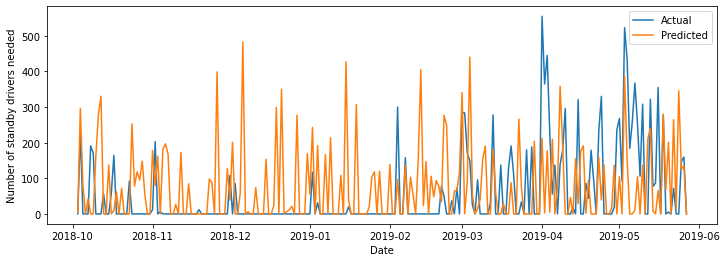

In [27]:
lr_pred = lr.predict(x_test)
lr_pred = list(map(lambda x: 0 if x < 0 else x, lr_pred))

plt.figure(figsize = (12, 4))
plt.plot(dates, y_test, label = 'Actual')
plt.plot(dates, lr_pred, label = 'Predicted')
plt.xlabel('Date')
plt.ylabel('Number of standby drivers needed')
plt.legend()
plt.savefig('Figure3.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)
plt.show()

Below five algorithms are built as well and the results are shown as dataframe.

In [28]:
gbr = GradientBoostingRegressor(random_state = 42)
svr = SVR()
ridge = Ridge()
lasso = Lasso()
rfr   = RandomForestRegressor(random_state = 42)
results.append(fit2model(x_train, x_test, y_train, y_test, gbr, 'Gradient Boosting Regression'))
results.append(fit2model(x_train, x_test, y_train, y_test, svr, 'Support Vector Regression'))
results.append(fit2model(x_train, x_test, y_train, y_test, ridge, 'Ridge Regression'))
results.append(fit2model(x_train, x_test, y_train, y_test, lasso, 'Lasso Regression'))
results.append(fit2model(x_train, x_test, y_train, y_test, rfr, 'Random Forest Regression'))

pd.DataFrame(results, columns = columns)

,Algorithm,RMSE,Active Rate,Unattended Rate,Note
0,(n_sby = 90),112,26.5%,55.7%,Benchmark
1,Linear Regression,139,25.4%,63.5%,
2,Gradient Boosting Regression,98,43.7%,61.4%,
3,Support Vector Regression,119,38.8%,99.9%,
4,Ridge Regression,139,25.4%,63.5%,
5,Lasso Regression,136,25.5%,65.6%,
6,Random Forest Regression,93,42.9%,60.4%,


### Polynomial Features

As the above models didn't well, now features are newly engineered. </br>
Polynomical features with up to the degree of 6 are added.

In [29]:
print(df.shape)

for column in df.columns:
    if column == 'sby_need':
        continue
    for name in ['sby_need', 'n_sick', 'calls']:
        if column.startswith(name):
            df[f'{column}_2d'] = df[column] ** 2
            df[f'{column}_3d'] = df[column] ** 3
            df[f'{column}_4d'] = df[column] ** 4
            df[f'{column}_5d'] = df[column] ** 5
            df[f'{column}_6d'] = df[column] ** 6
            break
        
print(df.shape)

(787, 1429)
(787, 6229)


Dataset with polynomical features looks like below.

In [30]:
df.head()

,sby_need,wknd,hldy,wknd_hldy,dyofwk_Mon,dyofwk_Sat,dyofwk_Sun,dyofwk_Thu,dyofwk_Tue,dyofwk_Wed,...,n_sick-365d_2d,n_sick-365d_3d,n_sick-365d_4d,n_sick-365d_5d,n_sick-365d_6d,calls-365d_2d,calls-365d_3d,calls-365d_4d,calls-365d_5d,calls-365d_6d
365,200.0,1,0,1,0,1,0,0,0,0,...,5329.0,389017.0,28398241.0,2.073072e+09,1.513342e+11,66487716.0,5.421408e+11,4.420616e+15,3.604571e+19,2.939167e+23
366,0.0,1,0,1,0,0,1,0,0,0,...,4096.0,262144.0,16777216.0,1.073742e+09,6.871948e+10,72692676.0,6.197778e+11,5.284225e+15,4.505330e+19,3.841245e+23
367,283.0,0,0,0,1,0,0,0,0,0,...,4624.0,314432.0,21381376.0,1.453934e+09,9.886748e+10,65415744.0,5.290825e+11,4.279220e+15,3.461033e+19,2.799283e+23
368,117.0,0,0,0,0,0,0,0,1,0,...,5041.0,357911.0,25411681.0,1.804229e+09,1.281003e+11,49617936.0,3.495087e+11,2.461940e+15,1.734190e+19,1.221564e+23
369,0.0,0,0,0,0,0,0,0,0,1,...,3969.0,250047.0,15752961.0,9.924365e+08,6.252350e+10,52359696.0,3.788748e+11,2.741538e+15,1.983777e+19,1.435461e+23


### Feature Selection

In order to select features that are actually conducive to the target variable, the correlation is calculated.

In [31]:
corr = df.corr()

'df_pruned' is defined as the dataframe with selected features. </br>
In the below code, those features whose absolute coefficients are less than 0.2 are dropped.

In [32]:
df_pruned = df.copy()

print(df_pruned.shape)

for column in corr.columns:
    correlation = corr.loc['sby_need', column]
    if abs(correlation) < 0.2:
        df_pruned.drop(column, axis = 1, inplace = True)

print(df_pruned.shape)

(787, 6229)
(787, 352)


'df_pruned' looks like below now.

In [33]:
df_pruned.head()

,sby_need,dyofyr_366,wkofyr_13,n_sick-58d,n_sick-59d,n_sick-60d,sby_need-61d,n_sick-190d,n_sick-193d,n_sick-194d,...,calls-364d_6d,sby_need-365d_2d,sby_need-365d_3d,sby_need-365d_4d,sby_need-365d_5d,calls-365d_2d,calls-365d_3d,calls-365d_4d,calls-365d_5d,calls-365d_6d
365,200.0,0,1,50.0,48.0,56.0,0.0,76.0,72.0,75.0,...,3.841245e+23,16.0,64.0,256.0,1.024000e+03,66487716.0,5.421408e+11,4.420616e+15,3.604571e+19,2.939167e+23
366,0.0,0,0,54.0,50.0,48.0,0.0,71.0,80.0,72.0,...,2.799283e+23,4900.0,343000.0,24010000.0,1.680700e+09,72692676.0,6.197778e+11,5.284225e+15,4.505330e+19,3.841245e+23
367,283.0,0,0,44.0,54.0,50.0,0.0,79.0,77.0,80.0,...,1.221564e+23,0.0,0.0,0.0,0.000000e+00,65415744.0,5.290825e+11,4.279220e+15,3.461033e+19,2.799283e+23
368,117.0,0,0,48.0,44.0,54.0,19.0,80.0,76.0,77.0,...,1.435461e+23,0.0,0.0,0.0,0.000000e+00,49617936.0,3.495087e+11,2.461940e+15,1.734190e+19,1.221564e+23
369,0.0,0,0,58.0,48.0,44.0,0.0,90.0,71.0,76.0,...,7.486366e+22,0.0,0.0,0.0,0.000000e+00,52359696.0,3.788748e+11,2.741538e+15,1.983777e+19,1.435461e+23


Taking a look at features whose coefficients are higher than 0.3.

In [34]:
coefs = []
columns_coef = ['feature', 'coefficient']

for column in corr.columns:
    correlation = corr.loc['sby_need', column]
    if abs(correlation) > 0.3:
        coefs.append([column, np.round(correlation, 2)])
        
pd.DataFrame(coefs, columns = columns_coef)

,feature,coefficient
0,sby_need,1.00
1,calls-365d,0.32
2,n_sick-226d_6d,0.30
3,n_sick-227d_4d,0.30
4,n_sick-227d_5d,0.32
5,n_sick-227d_6d,0.32
6,calls-334d_3d,0.31
7,calls-334d_4d,0.31
8,calls-334d_5d,0.32
9,calls-334d_6d,0.32


### Train Test Split with Selected Features

The dataset is once again split into training and test datasets, now that features are engineered and selected.

In [35]:
x = df_pruned.drop('sby_need', axis = 1)
y = df_pruned['sby_need']

x_train, x_test, y_train, y_test = train_test_split(x.values, y.values,
                                                    test_size = 0.3,
                                                    shuffle   = False)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(550, 351)
(550,)
(237, 351)
(237,)


### Fitting to Models

Fitting the same models as above but to the dataset with features engineered and selected. </br>
Results are shown as in the form of dataframe.

In [36]:
lr  = LinearRegression()
gbr = GradientBoostingRegressor(random_state = 42)
svr = SVR()
ridge = Ridge()
lasso = Lasso()
rfr   = RandomForestRegressor(random_state = 42)

results.append(fit2model(x_train, x_test, y_train, y_test, lr, 'Linear Regression', 'Features Modified'))
results.append(fit2model(x_train, x_test, y_train, y_test, gbr, 'Gradient Boosting Regression', 'Features Modified'))
results.append(fit2model(x_train, x_test, y_train, y_test, svr, 'Support Vector Regression', 'Features Modified'))
results.append(fit2model(x_train, x_test, y_train, y_test, ridge, 'Ridge Regression', 'Features Modified'))
results.append(fit2model(x_train, x_test, y_train, y_test, lasso, 'Lasso Regression', 'Features Modified'))
results.append(fit2model(x_train, x_test, y_train, y_test, rfr, 'Random Forest Regression', 'Features Modified'))

pd.DataFrame(results, columns = columns)

,Algorithm,RMSE,Active Rate,Unattended Rate,Note
0,(n_sby = 90),112,26.5%,55.7%,Benchmark
1,Linear Regression,139,25.4%,63.5%,
2,Gradient Boosting Regression,98,43.7%,61.4%,
3,Support Vector Regression,119,38.8%,99.9%,
4,Ridge Regression,139,25.4%,63.5%,
5,Lasso Regression,136,25.5%,65.6%,
6,Random Forest Regression,93,42.9%,60.4%,
7,Linear Regression,113,35.0%,63.8%,Features Modified
8,Gradient Boosting Regression,96,43.4%,49.4%,Features Modified
9,Support Vector Regression,118,51.1%,99.7%,Features Modified


Plotting the prediction with the best metrics.

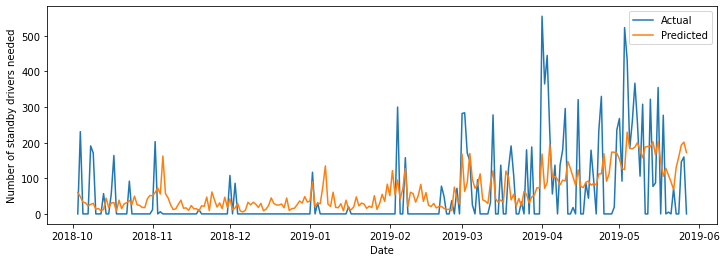

In [37]:
rfr_pred = rfr.predict(x_test)
rfr_pred = list(map(lambda x: 0 if x < 0 else x, rfr_pred)) # If a prediction is below 0, it is altered to 0

plt.figure(figsize = (12, 4))
plt.plot(dates, y_test, label = 'Actual')
plt.plot(dates, rfr_pred, label = 'Predicted')
plt.xlabel('Date')
plt.ylabel('Number of standby drivers needed')
plt.savefig('Figure4.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)
plt.legend()
plt.show()

### Time Series Regression with RNN, LSTM, and GRU

Defining the above function with the three metrics for deep learning models.

In [38]:
def fit2model_dl(x, y, model, algorithm, note):
    # Creating scalers for x and y
    x_scaler = MinMaxScaler(feature_range = (0, 1))
    y_scaler = MinMaxScaler(feature_range = (0, 1))
    
    # Scaling x & y
    x = x_scaler.fit_transform(x.values)
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
    
    # Splitting into x & y into train & test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle = False)

    # reshaping x datasets
    x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
    x_test  = x_test.reshape(x_test.shape[0],   1, x_test.shape[1])
    
    # Fitting to the model
    hist = model.fit(x_train, y_train,
                     epochs          = 15,
                     batch_size      = 1,
                     verbose         = 0)
    
    # Outputting the prediction
    pred  = model.predict(x_test)
    
    # Descaling the predicted and actual values
    y_test = y_scaler.inverse_transform(y_test)
    pred   = y_scaler.inverse_transform(pred.reshape(-1, 1))
    
    # Reshaping the predicted and actual values into 1 dimension
    y_test = y_test.reshape(-1)
    pred   = pred.reshape(-1)
    
    # Calculating metrics and adding remarks
    result = []
    result.append(algorithm)
    result.append(RMSE(y_test, pred))
    result.append(active_rate(y_test, pred))
    result.append(unattended_rate(y_test, pred))
    result.append(note)
    
    return result

RNN, LSTM, and GRU models with 1 layer for each model.

In [39]:
model = Sequential()
model.add(SimpleRNN(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')

results.append(fit2model_dl(x, y, model, 'RNN', '1 RNN layer'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [40]:
model = Sequential()
model.add(LSTM(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')

results.append(fit2model_dl(x, y, model, 'LSTM', '1 LSTM layer'))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [41]:
model = Sequential()
model.add(GRU(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')

results.append(fit2model_dl(x, y, model, 'GRU', '1 GRU layer'))

RNN, LSTM, and GRU models with 3 layers for each model.

In [42]:
model = Sequential()
model.add(SimpleRNN(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(SimpleRNN(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(SimpleRNN(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')

results.append(fit2model_dl(x, y, model, 'RNN', '3 RNN layers'))

In [43]:
model = Sequential()
model.add(LSTM(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')

results.append(fit2model_dl(x, y, model, 'LSTM', '3 LSTM layers'))

RNN, LSTM, and GRU models with 3 layers with Dropout for each model.

In [44]:
model = Sequential()
model.add(GRU(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(GRU(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(GRU(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')

results.append(fit2model_dl(x, y, model, 'GRU', '3 GRU layers'))

In [45]:
model = Sequential()
model.add(SimpleRNN(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')

results.append(fit2model_dl(x, y, model, 'RNN', '3 RNNs layers with Dropout'))

In [46]:
model = Sequential()
model.add(LSTM(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')

results.append(fit2model_dl(x, y, model, 'LSTM', '3 LSTMs layers with Dropout'))

In [47]:
model = Sequential()
model.add(GRU(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(300, input_shape = (1, x.shape[1]), return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')

results.append(fit2model_dl(x, y, model, 'GRU', '3 GRUs layers with Dropout'))

Shown below are all the models' results.

In [48]:
pd.DataFrame(results, columns = columns)

,Algorithm,RMSE,Active Rate,Unattended Rate,Note
0,(n_sby = 90),112,26.5%,55.7%,Benchmark
1,Linear Regression,139,25.4%,63.5%,
2,Gradient Boosting Regression,98,43.7%,61.4%,
3,Support Vector Regression,119,38.8%,99.9%,
4,Ridge Regression,139,25.4%,63.5%,
5,Lasso Regression,136,25.5%,65.6%,
6,Random Forest Regression,93,42.9%,60.4%,
7,Linear Regression,113,35.0%,63.8%,Features Modified
8,Gradient Boosting Regression,96,43.4%,49.4%,Features Modified
9,Support Vector Regression,118,51.1%,99.7%,Features Modified


As the above table shows, random forest regression with features modified did best among all the models.

Below shows a closer look. </br>
RMSE is lower by more than 20, the active rate higher by more than 15%, and the unattended rate lower by more than 5%.

In [49]:
pd.DataFrame(results, columns = columns).loc[[0, 12], :]

,Algorithm,RMSE,Active Rate,Unattended Rate,Note
0,(n_sby = 90),112,26.5%,55.7%,Benchmark
12,Random Forest Regression,90,42.6%,50.2%,Features Modified


EOF